In [ ]:
NO ESTA TERMINADO NADA DE ESTO PROFE, FAVOR NO CONSIDERAR EL DE LAS 12:00, falta toda la parte de visualizacion 

In [ ]:
#objetivo principal: clasificar en 4 clases: fondo, 1, 2, 3

In [ ]:
!git reset --hard && git pull

In [ ]:
#test passing blocks

### todo list: 


- ~~ aplicar transformaciones al dataset ~~
- <s>transfer learning resnet 50</s>
- <s>evaluar ambos modelos 5 veces</s>
- implement early stopping
- obtener matriz de confusion y mostrar diferencias 
- visualizar los diferentes entrenamientos (por el momento solo en tensorboard, falta devolver las variables de las funciones
- code refactory
- devolver todas las accuracys de la funcion 
- probar sin pooling 

In [9]:
%matplotlib inline  
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from PIL import Image
import os
import sys
import pandas as pd

# Datos 

In [ ]:
#esta balanceado???

In [2]:
!ls ./gestos/train/0 | wc -l
!ls ./gestos/train/1 | wc -l
!ls ./gestos/train/2 | wc -l
!ls ./gestos/train/3 | wc -l

!ls ./gestos/valid/0 | wc -l
!ls ./gestos/valid/1 | wc -l
!ls ./gestos/valid/2 | wc -l
!ls ./gestos/valid/3 | wc -l

2500
2500
2500
2500
500
500
500
500


In [ ]:
#sí, lo esta!, punto para nosotros...

### Transforms - Augmentation

In [10]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    #torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                       saturation=0.5, hue=0.0),
    torchvision.transforms.ToTensor()
    
])

### train data set and data loader

In [3]:
user = os.getenv('USER')
if (user == "felipesaldias"):
    ds_route= "./"
else: 
    ds_route= "/opt/data-nas/Fsaldias/"


In [4]:

train_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/train/', transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


### test data set and data loader
lo unico que merece la pena la mecion aqui es que el batch lo intentamos hacer de 2000 para pasar todos los ejemplos de una y se caia por memoria vram

In [5]:
val_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor()
    ])

valid_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/valid', transform = val_transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=False,
                                          num_workers=4)


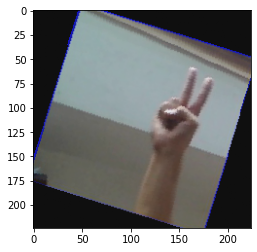

In [12]:
#bloque de comprension de donde queda la imagen 
iterable= iter(train_loader)
elemento_del_iterable = next(iterable) #contiene en el [0] los 16 ejemplos de las fotos y en el [1] las clases de estos
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1].numpy().transpose((1,2,0)))#.reshape(224,224,3))

# creacion del modelo

PROBAMOS VARIANDO NEURONAS, VARIANDO EL MAXPOOL, TENIENDO TANTAS COSAS QUE CONTROLAR UNO PREFIERE OBVIAR ALGUNAS Y NOS CONCENTRAMOS EN PROBAR DIFERENTES COMBINACIONES DE CAPAS.

al manipular capas fc, poniendo capas intermedias entre las arquitectura lenet5 clasica y nuestra propuesta no pudimos conseguir mejores resultados 


principalmente variamos las capas convolucionales y jugamos con algunas sin max pooling, para evaluar, puede encontrar algunas referencias que anotamos en el cuaderno anexo1.pdf, al aumentar las capas convolucionales en una y dos se podria tender a pensar que los resultados eran mejores, pero al intentar probar con 5 capas convolucionales se obtuvieron resultados peores

In [6]:
class OTT_Classifier(torch.nn.Module):
    
    def __init__(self):
        super(OTT_Classifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=4, in_channels=3, out_channels=6)
        self.conv2 = torch.nn.Conv2d(kernel_size=4, in_channels=6, out_channels=16)
        self.conv3 = torch.nn.Conv2d(kernel_size=4, in_channels=16, out_channels=32)
        self.conv4 = torch.nn.Conv2d(kernel_size=4, in_channels=32, out_channels=64)

        self.mpool = torch.nn.MaxPool2d(kernel_size=2)
        self.activation = torch.nn.ReLU()#torch.nn.LeakyReLU()
        self.activation2 = torch.nn.Softmax(dim=1)
        self.linear1 = torch.nn.Linear(in_features=64*11*11 ,out_features=120)
        self.linear2 = torch.nn.Linear(in_features=120 ,out_features=84)
        self.linear3 = torch.nn.Linear(in_features=84 ,out_features=4)
        
        pass
                     
    def forward(self, x):
        h = self.mpool((self.activation(self.conv1(x))))
        h = self.mpool((self.activation(self.conv2(h))))
        h = self.mpool((self.activation(self.conv3(h))))
        h = self.mpool((self.activation(self.conv4(h))))
        #print(h.shape)
        h = h.view(-1, self.linear1.in_features)
        h = self.activation(self.linear1(h))
        h = self.activation(self.linear2(h))
        h = self.activation2(self.linear3(h))
        return h
                     
                    
                     
#hacer pasar un ejemplo 
#image = torch.tensor(np.zeros((1,3,200,200)), dtype= torch.float32) #fake example
model = OTT_Classifier()       
display((model.forward(valid_dataset[1][0].unsqueeze(0)).argmax(dim=1).detach().numpy())[0])

    
                     

1

# Entrenamiento

 La eleccion del criterio es casi algo obligatorio ya que al ser nuestro objetivo una clasificacion multiclase debemos utilizar la CrossEntropyLoss 
 
 En cuanto al optimizador, se opto por Adam por ser la primera red convolucional que estamos desarrollando y se ve que es muy utilizado en la literatura, preferimos no complicarnos en esto teniendo tanto que ajustar. como el learning rate del optimizador que solo a prueba y error variandolo se opto por quedarnos con el mismo que habiamos comenzando 

In [7]:
import time
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def please_train_it(name, epochs):

    max_epochs = epochs
    torch.manual_seed(1234) # Inicialización

    model = OTT_Classifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss(reduction='sum') #debido a la clasificacion multiclase

    #to device
    device = torch.device('cuda:0')
    model = model.to(device)


    def train_one_step(batch):#batch):
        optimizer.zero_grad()
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        return loss.item() 
    
    
    def evaluate_one_step(x, y):
        with torch.no_grad():
            #x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            return y, yhat, loss.item()
    
        
    def log_results(name, epochs, loss, valid_accuracy, best_epoch,
                    best_valid_loss, best_valid_loss_accuracy, 
                    best_valid_loss_accuracy_by_class, time): 
        original_stdout = sys.stdout
        with open(f'./logs/{name}_logs.txt', "w", encoding="utf-8") as file:
            sys.stdout = file
            print("Nombre: ", name)
            print("Epoch", "Train_loss", "Val_loss", "gral_accuracy")
            index= np.append(np.arange(0, epochs).reshape(epochs,1), loss, axis=1)
            data= np.append(index, valid_accuracy.reshape(epochs,1), axis= 1)
            print(data)
            print("your train takes around : ", time, "seconds")
            print("the best val_loss was in epoch :", best_epoch)
            print("con una loss de: ", best_valid_loss)
            print("y una presicion gral de : ", best_valid_loss_accuracy)
            print("y una presicion por clase de : ", best_valid_loss_accuracy_by_class)
            print("______________________________________")
            
            sys.stdout = original_stdout

    
    writer = SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}')
    
    #criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    running_loss = np.zeros(shape=(max_epochs, 2))
    valid_accuracy = np.zeros(max_epochs)
    best_valid_loss = np.inf
    best_valid_loss_accuracy = 0.
    best_valid_loss_accuracy_by_class = np.zeros(4)
    best_epoch= -1
    best_y= 0
 

    ##entrenamiento 
    t= time.time()
    for epoch in range(max_epochs):
    
        t1= time.time()
        train_loss, valid_loss = 0.0, 0.0
    
        #model.train()
        for batch in train_loader:
            # model.train()
            train_loss += train_one_step(batch)
        running_loss[epoch, 0] = train_loss/train_loader.dataset.__len__()   
        writer.add_scalar("Loss/train", train_loss, epoch)
    
        # Loop de validación
        y_pred = []
        y_true = []

        for samples, tags in valid_loader:

            y, yhat, loss= evaluate_one_step(samples, tags)
            
            y_true.append(y.cpu())
            y_pred.append(yhat.cpu().argmax(dim=1).detach().numpy())
            valid_loss += loss
            
        
        y_pred = np.concatenate(y_pred) #aplana todo a en una dim 
        y_true = np.concatenate(y_true)
    
        if((valid_dataset.targets == y_true).all):
            print("equals")
        val_loss = valid_loss/valid_loader.dataset.__len__()  
        accuracy = accuracy_score(y_true, y_pred)
        print("Accuracy: ", accuracy)
        #display(y_pred)
        
        
        # accuracy by class
        matrix = confusion_matrix(y_true, y_pred)
        print("Accuracy by class: ",matrix.diagonal()/matrix.sum(axis=1))
        
        #guardamos todas las variables que queremos
        valid_accuracy[epoch]= accuracy 
        running_loss[epoch, 1] = val_loss    
        writer.add_scalar("valid/loss", val_loss, epoch)
        writer.add_scalar("valid/accuracy", accuracy, epoch)
    
    
        # Guardar modelo si es el mejor hasta ahora    
        if val_loss < best_valid_loss:
            print("best_valid_loss replaced: ", val_loss)
            best_epoch=epoch
            best_valid_loss = val_loss
            best_valid_loss_accuracy = accuracy
            matrix = confusion_matrix(y_true, y_pred)
            best_valid_loss_accuracy_by_class= matrix.diagonal()/matrix.sum(axis=1)
            best_y = y_pred
        
            
            torch.save({'current_epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'current_valid_loss': valid_loss
                       }, f'{name}best_model.pt')
            
        print(time.time()-t1)
        
        print("ENDDDDDDD EPOCH") 
    log_results(name, max_epochs, running_loss, valid_accuracy, best_epoch, best_valid_loss, 
                best_valid_loss_accuracy, best_valid_loss_accuracy_by_class, time.time()-t
               )
    return best_y



# Evaluacion del modelo preliminar con datos de ajuste


decidimos no cargar los pesos nuevamente aqui y en vez de esto, manejar todo en memoria para no tener que estar reconstruyendo el modelo con los mejores pesos antes de evaluar, se mantienen los datos de la mejor epoca (con menor accuracy)

el siguiente bloque de codigo se utiliza para ejecutar el experimento 4 veces y recuperar las metricas 

In [8]:
from sklearn.metrics import precision_recall_fscore_support 
arreglo = [None] * 5
medias = [None] * 5
y_true=valid_dataset.targets 
times= 5

for i in range(times):
    y_pred = please_train_it(f"EXPERIMENT_{i}", 100)
    metrics = precision_recall_fscore_support(y_true, y_pred)
    df =pd.DataFrame(metrics, columns=["0", "1", "2", "3"], index=["precision", "recall", "fscore", "support"]).drop("support")
    series_medias= pd.Series(df.mean(axis=1),name= "media")
    df_mean= pd.concat([df,series_medias],axis= 1)
    arreglo[i] = df_mean
    medias[i] = series_medias
df= pd.concat(arreglo, axis=0, keys=range(times))
#display(df)
mean = pd.concat(medias, axis=1, keys=range(times)).mean(axis=1)
std = pd.concat(medias, axis=1, keys=range(times)).std(axis=1)

equals
Accuracy:  0.5185
Accuracy by class:  [1.    1.    0.    0.074]
best_valid_loss replaced:  1.2331260004043578
10.004972457885742
ENDDDDDDD EPOCH
equals
Accuracy:  0.563
Accuracy by class:  [1.    0.582 0.    0.67 ]
best_valid_loss replaced:  1.166323700428009
9.942819118499756
ENDDDDDDD EPOCH
equals
Accuracy:  0.515
Accuracy by class:  [0.912 0.392 0.172 0.584]
9.965118885040283
ENDDDDDDD EPOCH
equals
Accuracy:  0.64
Accuracy by class:  [0.984 0.844 0.252 0.48 ]
best_valid_loss replaced:  1.102214156627655
10.044224500656128
ENDDDDDDD EPOCH
equals
Accuracy:  0.6745
Accuracy by class:  [1.    0.946 0.134 0.618]
best_valid_loss replaced:  1.0674234080314635
9.979281902313232
ENDDDDDDD EPOCH
equals
Accuracy:  0.64
Accuracy by class:  [0.68  0.936 0.084 0.86 ]
10.012611627578735
ENDDDDDDD EPOCH
equals
Accuracy:  0.7515
Accuracy by class:  [1.    0.994 0.272 0.74 ]
best_valid_loss replaced:  0.9849813151359558
10.009854078292847
ENDDDDDDD EPOCH
equals
Accuracy:  0.608
Accuracy by cla

equals
Accuracy:  0.6315
Accuracy by class:  [1.    0.514 0.014 0.998]
9.92769742012024
ENDDDDDDD EPOCH
equals
Accuracy:  0.778
Accuracy by class:  [0.946 0.732 0.544 0.89 ]
9.940285682678223
ENDDDDDDD EPOCH
equals
Accuracy:  0.523
Accuracy by class:  [0.41  0.254 0.552 0.876]
9.976240873336792
ENDDDDDDD EPOCH
equals
Accuracy:  0.7435
Accuracy by class:  [0.932 0.706 0.82  0.516]
10.007104873657227
ENDDDDDDD EPOCH
equals
Accuracy:  0.5655
Accuracy by class:  [0.842 0.316 0.962 0.142]
9.960387945175171
ENDDDDDDD EPOCH
equals
Accuracy:  0.775
Accuracy by class:  [0.938 0.662 0.71  0.79 ]
9.975865364074707
ENDDDDDDD EPOCH
equals
Accuracy:  0.683
Accuracy by class:  [0.962 0.906 0.606 0.258]
9.95366621017456
ENDDDDDDD EPOCH
equals
Accuracy:  0.761
Accuracy by class:  [0.934 0.838 0.852 0.42 ]
9.963999271392822
ENDDDDDDD EPOCH
equals
Accuracy:  0.5905
Accuracy by class:  [0.79  0.466 0.868 0.238]
9.990626335144043
ENDDDDDDD EPOCH
equals
Accuracy:  0.4605
Accuracy by class:  [0.022 0.76  0.9

equals
Accuracy:  0.6185
Accuracy by class:  [1.    0.974 0.188 0.312]
9.953161239624023
ENDDDDDDD EPOCH
equals
Accuracy:  0.6555
Accuracy by class:  [1.    0.978 0.03  0.614]
9.948759078979492
ENDDDDDDD EPOCH
equals
Accuracy:  0.423
Accuracy by class:  [1.    0.674 0.    0.018]
10.03095030784607
ENDDDDDDD EPOCH
equals
Accuracy:  0.6185
Accuracy by class:  [1.    0.982 0.086 0.406]
10.067815065383911
ENDDDDDDD EPOCH
equals
Accuracy:  0.662
Accuracy by class:  [1.    0.966 0.194 0.488]
9.929028511047363
ENDDDDDDD EPOCH
equals
Accuracy:  0.785
Accuracy by class:  [1.    0.944 0.486 0.71 ]
9.95846152305603
ENDDDDDDD EPOCH
equals
Accuracy:  0.77
Accuracy by class:  [1.    0.97  0.568 0.542]
9.972114324569702
ENDDDDDDD EPOCH
equals
Accuracy:  0.5105
Accuracy by class:  [1.    0.972 0.    0.07 ]
9.966908693313599
ENDDDDDDD EPOCH
equals
Accuracy:  0.618
Accuracy by class:  [1.    0.956 0.21  0.306]
10.039000749588013
ENDDDDDDD EPOCH
equals
Accuracy:  0.8045
Accuracy by class:  [1.    0.962 0.

equals
Accuracy:  0.7405
Accuracy by class:  [0.9   0.936 0.73  0.396]
9.968874454498291
ENDDDDDDD EPOCH
equals
Accuracy:  0.7645
Accuracy by class:  [0.664 0.768 0.96  0.666]
10.01953911781311
ENDDDDDDD EPOCH
equals
Accuracy:  0.673
Accuracy by class:  [0.884 0.96  0.556 0.292]
9.997627973556519
ENDDDDDDD EPOCH
equals
Accuracy:  0.714
Accuracy by class:  [1.    0.954 0.446 0.456]
9.997001647949219
ENDDDDDDD EPOCH
equals
Accuracy:  0.768
Accuracy by class:  [0.944 0.948 0.82  0.36 ]
9.926711320877075
ENDDDDDDD EPOCH
equals
Accuracy:  0.852
Accuracy by class:  [1.    0.868 0.768 0.772]
best_valid_loss replaced:  0.8911366791725158
9.986538648605347
ENDDDDDDD EPOCH
equals
Accuracy:  0.8325
Accuracy by class:  [1.    0.946 0.668 0.716]
9.997440576553345
ENDDDDDDD EPOCH
equals
Accuracy:  0.754
Accuracy by class:  [1.    0.976 0.594 0.446]
10.041776180267334
ENDDDDDDD EPOCH
equals
Accuracy:  0.638
Accuracy by class:  [0.702 0.818 0.86  0.172]
10.014005899429321
ENDDDDDDD EPOCH
equals
Accura

equals
Accuracy:  0.4985
Accuracy by class:  [0.93  1.    0.    0.064]
best_valid_loss replaced:  1.2375875086784363
10.017340660095215
ENDDDDDDD EPOCH
equals
Accuracy:  0.5535
Accuracy by class:  [1.    0.958 0.    0.256]
best_valid_loss replaced:  1.175421941757202
9.992124080657959
ENDDDDDDD EPOCH
equals
Accuracy:  0.635
Accuracy by class:  [1.    0.996 0.03  0.514]
best_valid_loss replaced:  1.1012676825523378
10.12091326713562
ENDDDDDDD EPOCH
equals
Accuracy:  0.658
Accuracy by class:  [1.    0.998 0.024 0.61 ]
best_valid_loss replaced:  1.0825452780723572
10.008378505706787
ENDDDDDDD EPOCH
equals
Accuracy:  0.692
Accuracy by class:  [1.    0.58  0.438 0.75 ]
best_valid_loss replaced:  1.049142367362976
10.046425342559814
ENDDDDDDD EPOCH
equals
Accuracy:  0.7425
Accuracy by class:  [0.862 0.8   0.514 0.794]
best_valid_loss replaced:  0.9981891980171204
10.043022155761719
ENDDDDDDD EPOCH
equals
Accuracy:  0.766
Accuracy by class:  [1.    0.95  0.272 0.842]
best_valid_loss replaced:

equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.947859525680542
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.995511054992676
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.93938136100769
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.978034973144531
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.942349433898926
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
10.000045537948608
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.954271793365479
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.969965696334839
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.984965562820435
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
9.91338062286377
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 1. 0.]
10.045543432235718
ENDDDDDDD EPOCH

equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
10.090831995010376
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.950253248214722
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.948630332946777
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
10.047871351242065
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.915280103683472
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.936418533325195
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
10.027440547943115
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.982600450515747
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.97923469543457
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.99633502960205
ENDDDDDDD EPOCH
equals
Accuracy:  0.25
Accuracy by class:  [0. 0. 0. 1.]
9.908559322357178
ENDDDDDDD EPOC

el siguiente df resume las metricas mas importantes del entrenamiento hecho arriba, claramente nos quedaremos con los pesos de la priemra iteracion que alcanza una precision de 0.93945

In [11]:
#resumen datos
display(df)

0         1         2         3     media
0 precision  1.000000  0.959677  0.814751  0.983373  0.939450
  recall     1.000000  0.952000  0.950000  0.828000  0.932500
  fscore     1.000000  0.955823  0.877193  0.899023  0.933010
1 precision  0.980392  0.895146  0.825743  0.865957  0.891809
  recall     1.000000  0.922000  0.834000  0.814000  0.892500
  fscore     0.990099  0.908374  0.829851  0.839175  0.891875
2 precision  0.984252  0.939583  0.735390  0.919192  0.894604
  recall     1.000000  0.902000  0.906000  0.728000  0.884000
  fscore     0.992063  0.920408  0.811828  0.812500  0.884200
3 precision  1.000000  0.920518  0.823643  0.914221  0.914596
  recall     1.000000  0.996000  0.850000  0.810000  0.914000
  fscore     1.000000  0.956772  0.836614  0.858961  0.913087
4 precision  1.000000  0.869245  0.634146  0.878553  0.845486
  recall     0.910000  0.944000  0.780000  0.680000  0.828500
  fscore     0.952880  0.905081  0.699552  0.766629  0.831035

In [24]:
#df.to_pickle("./ownredsummary.pkl")
#mean.to_pickle("./ownred_mean.pkl")
#std.to_pickle("./ownred_std.pkl")

## Graficando 

el siguiente grafico es generado por el promedio de los 5 entrenamientos realizados en la seccion anterior, con sus respectivas barras de error.
los datos utilizados para las gráficas pueden ser encontrados en los archivos de texto dentro de la carpeta logs

In [22]:
!ls logs

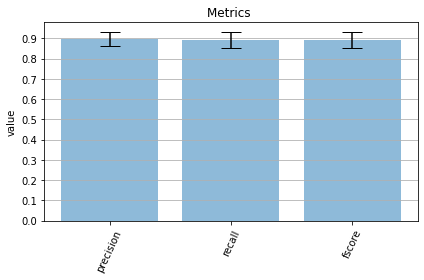

In [20]:
%matplotlib inline  
fig, ax = plt.subplots()
ax.bar(range(3), mean.values, yerr=std.values,align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('value')
ax.set_xticks(range(3))
ax.set_title('Metrics ')
ax.yaxis.grid(True)

ax.set_xticklabels(["precision", "recall", "fscore"], rotation=65)
ax.set_yticks(np.arange(0,1,0.1))
# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()


# conjunto de test

In [ ]:

test_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/test/', transform = torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=120, ##TODO: ajustar este tamaño
                                          shuffle=false,
                                          num_workers=4)

In [ ]:
#grafiquito del entrenamiento tensorboard

Despues de correr las 5 vueltas podemos percatarnos que la mejor es ... por lo que probaremos el conjunto de validacion con esos pesos 

In [ ]:
model = model = OTT_Classifier() 
model.load_state_dict(torch.load('./EXPERIMENT\:0best_model.pt'))

In [ ]:
targets, predictions = [], []
for mbdata, label in test_loader:
    logits = model.forward(mbdata)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(label.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(targets, predictions)
display(cm)

print(classification_report(targets, predictions))

In [ ]:
# TODO: dataframes bonitos con las comparaciones y links a los pesos finales de los modelos 

# TRANSFER LEARNING

# resnet 50
https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-pytorch

In [28]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
    ])

train_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/train/', transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


In [29]:
max_epochs= 10
device = torch.device('cuda:0')
def please_launch_transfer_learning(name):
    
    best = {
        "y_pred": 0,
        "valid_loss": 0,
        "accuracy": 0
    }
    
    best_valid_loss = np.inf
    model = torchvision.models.resnet18(pretrained=True)

    #Congelamos todos los parámetros
    for param in model.parameters(): 
        param.requires_grad = False

    # Recuperamos el número de neuronas de la última capa
    neurons = model.fc.in_features 
    # La reemplazamos por una nueva capa de salida
    model.fc = torch.nn.Linear(neurons, 4) 
    #model.fc = torch.nn.Sequential(
    #           torch.nn.Linear(neurons, 4),
    #           torch.nn.Softmax(dim=1)).to(device)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    
    for epoch in range(max_epochs):
        #train the model
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
        
        #eval the model    
        y_pred = []
        epoch_loss = 0.0
        model.eval()
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            y_pred.append(yhat.cpu().argmax(dim=1).detach().numpy())
            loss = criterion(yhat, y)
            epoch_loss += loss.item()
        y_pred = np.concatenate(y_pred)
        val_loss= epoch_loss/valid_loader.dataset.__len__()
        ###########
        accuracy = accuracy_score(valid_dataset.targets, y_pred)
        print("Accuracy: ", accuracy)
        print(epoch, epoch_loss/valid_loader.dataset.__len__() )
        ############
        ## save it if is better
        if val_loss < best_valid_loss:
            print("best_valid_loss replaced: ", epoch_loss/valid_loader.dataset.__len__())
            best["y_pred"] = y_pred #si guardamos esto evitamos tener que cargar los mejores pesos solamente para evaluar y sacar las metricas
            best["valid_loss"] = epoch_loss/valid_loader.dataset.__len__()
            best["accuracy"] = accuracy_score(valid_dataset.targets, y_pred)
            best_valid_loss = epoch_loss/valid_loader.dataset.__len__()
            
            torch.save({'current_epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'current_valid_loss': epoch_loss/valid_loader.dataset.__len__()
                       }, f'{name}_TL_best_model.pt')
            
    return best

## five times 

In [ ]:
from sklearn.metrics import precision_recall_fscore_support 
arreglo = [None] * 5
medias = [None] * 5
y_true=valid_dataset.targets 
times= 5

for i in range(times):
    best = please_launch_transfer_learning(f"TRANSFER_LEARNING_{i}", 50)
    metrics = precision_recall_fscore_support(y_true, best["y_pred"])
    df =pd.DataFrame(metrics, columns=["0", "1", "2", "3"], index=["precision", "recall", "fscore", "support"]).drop("support")
    series_medias= pd.Series(df.mean(axis=1),name= "media")
    df_mean= pd.concat([df,series_medias],axis= 1)
    arreglo[i] = df_mean
    medias[i] = series_medias
df= pd.concat(arreglo, axis=0, keys=range(times))
display(df)
mean = pd.concat(medias, axis=1, keys=range(times)).mean(axis=1)
std = pd.concat(medias, axis=1, keys=range(times)).std(axis=1)

## Graficando 

In [ ]:
%matplotlib inline  
fig, ax = plt.subplots()
ax.bar(range(3), mean.values, yerr=std.values,align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('value')
ax.set_xticks(range(3))
ax.set_title('Metrics ')
ax.yaxis.grid(True)

ax.set_xticklabels(["precision", "recall", "fscore"], rotation=65)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()


# Discusión preliminar
En general se ve como al modelo le cuesta siempre mucho mas reconocer la clase 3 (3 dedos) por sobre las clases restantes, es experto en reconocer nada, y al decir nada no nos referimos a nada, si no que a la ausencia de manos de la clase 0

In [ ]:
#bibliografia

#apis
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
    
    
#tutoriales

https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0
    https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch 
        https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16
            https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18
                https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-pytorch
                    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html #accuracy
                        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
                